## Classificació d'imatges - Xarxes Neuronals i Aprenentatge profund
## Dogs breed classifier


**Biel González Garriga    NIU: 1551813** 

**Sofia DiCapua --    NIU: 1603685** 

**Cristina Soler Arenys    NIU: 1603542**

Aquest quadern de Jupyter té com objectiu presentar els resultats obtinguts en el nostre projecte seguint els passos que hem anat completant. Totes les funcions que s'han usat les podreu trobar al github repartides en diferents scripts de python. Per poder entrenar models o provar-los s'haurà d'accedir al fitxer `main.py`. Altrament, per poder executar els scripts l'usuari ha de descarregar les dades de les imatges i guardar-les amb una carpeta, amb nom `Dogs-Breed-class` dins el projecte, d'aquesta maners assegurem un funcionament correcte.

**Índex**   
1. [Descripció de les dades](#id1)
2. [Importar les dades](#id2)
3. [Tractament de les dades](#id3)
4. [Entrenament amb model CNN - no preentrenat](#id4)
5. [Entrenament amb model CNN - preentrenat](#id5)
6. [Diferents formes d'entrenament](#id6)
7. [Aplicació en diferents dades](#id7)
8. [Test dels resultats](#id8)
9. [Evaluació qualitativa i quantitativa](#id9)


### Descripció de les dades<a name="id1"></a>
Se'ns proporciona una base de dades que ens permet fer la classificació de 120 raçes de gossos diferents, a partir d'imatges. Cada imathe té un nom de fitxer que és el seu identificador únic. L'objectiu és ccrear un classificador capaç de reconeixer i determinar la raça d'un gos a partir d'una foto.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\cristina soler\Documents\UNIVERSITAT programes\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
labels = pd.read_csv('Dog-Breed-classif/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Com podem observar disposem de 10222 imatges de test

In [3]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


Mirem com estaran distribuïdes les imatges segons les raçes per si n'hi ha alguna que predomini per sobre les altres i pogues provocar que l'entrenament s'esbiaixes. Com podem observar a la següent gràfica, la raça de gos amb més imatges és `scottish_deerhound` i el que menys `briard`, però la diferència d'imatges entre aquestes dues no creiem que pugui suposar un problema a l'hora d'entrenar

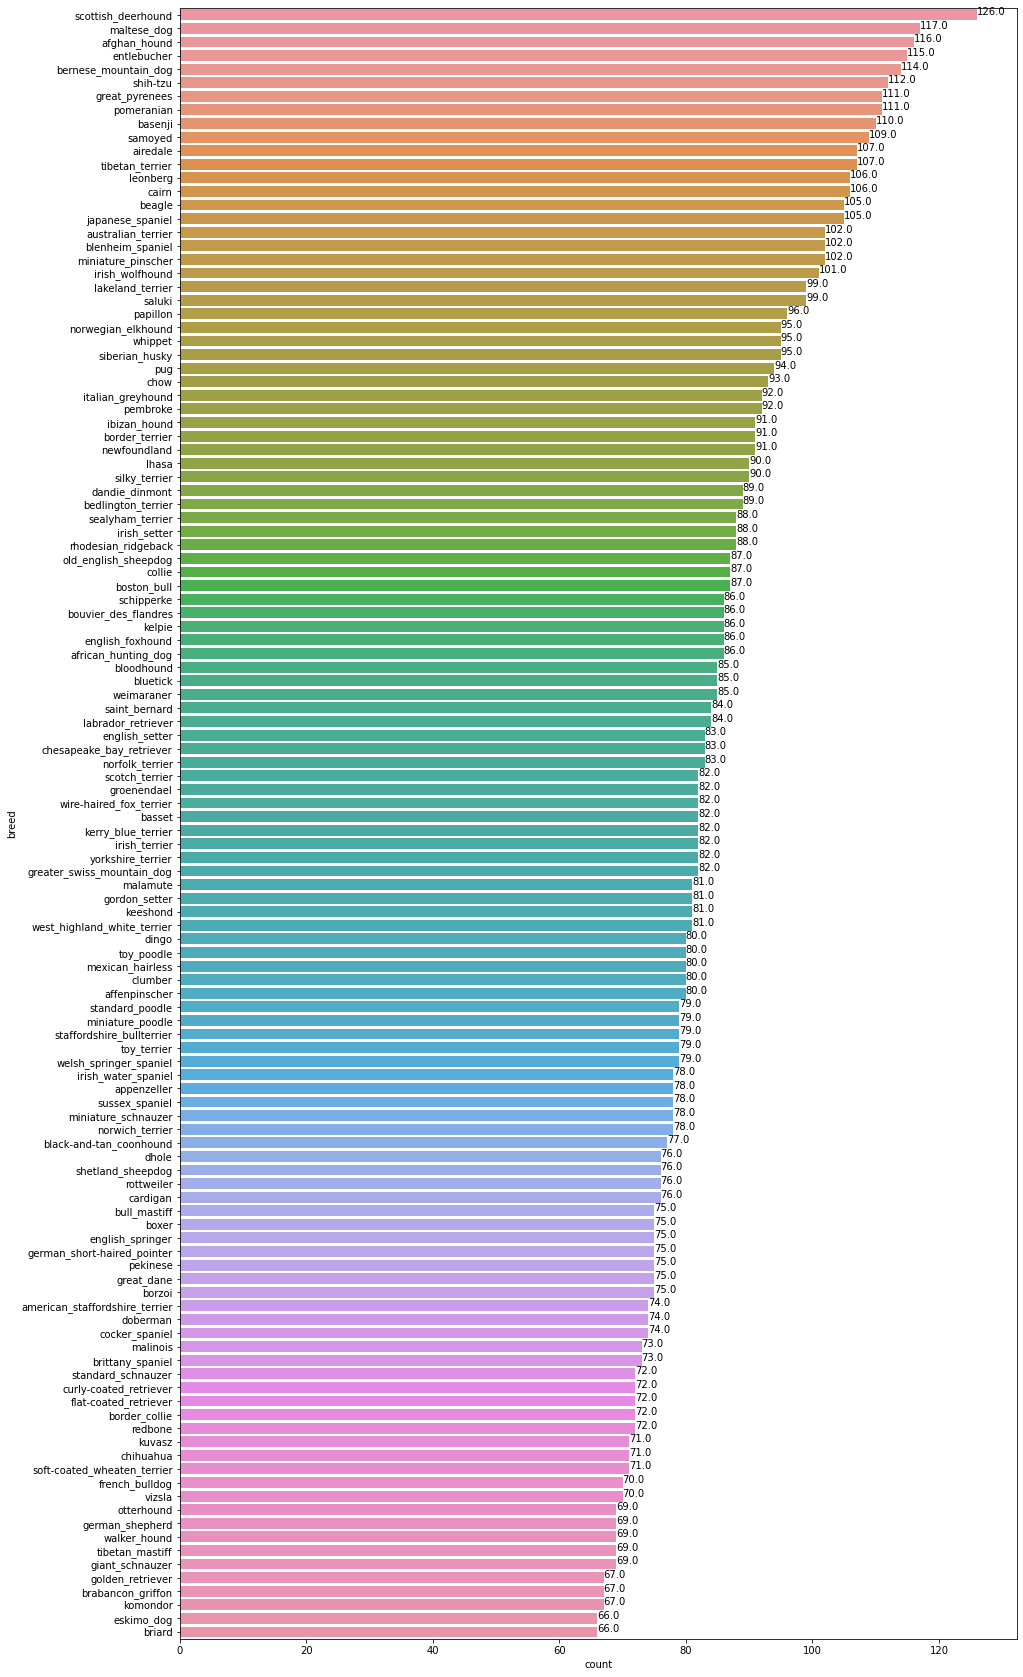

In [4]:
#function to show bar length
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

### Importar les dades<a name="id2"></a>

A la importació de les dades es important tenir descarregat el dataset que se'ns proporciona des de Kaggle i guardat dins una carpeta amb nom `Dogs-Breed-class`.

L'estructura de la carpeta de dades és la següent:
- `\train`: Trobarem les imatges que usarem en el train
- `\test`: Trobarem les imatges per fer proves, no podrem fer una comparació d'accuracy amb aquestes dades ja que no disposem dels valors dels labels reals.
- `labels.csv`: Arxiu csv on trobarem els identificadors de cada imatge amb la raça de gos correponent

Primerament, l'script que s'executarà és el de `FolderClassification.py` (el podeu trobar dins la carpeta de Data). Aquest script, crea carpetes amb noms de les raçes de gos, i ens organitza les imatges de train classificant-les dins la carpeta del nom de raça que li pertoca. Al fer aquest pas, se'ns facilita generar els dataloaders amb la classe propia de pytorch.


Un cop ja tenim les dades preparades, aplicarem el dataloader el que ens permetrà carregar les imatge i per posteriorment utilitzar-les en els nostres models. L'script que s'executarà es troba dins la carpeta Utils (`DataLoaders.py`). En aquest punt les nostres dades provinents de la carpeta de `train`quedan separades en 3 subsets de manera aleatoria. És a dir tindrem el subset: `train`, `val` i `test`, els quals ens permetran fer l'entrenament i mirar quina accuracy aconseguim.

### Tractament de les dades<a name="id3"></a>

### Entrenament amb model CNN - no preentrenat<a name="id4"></a>

### Entrenament amb model CNN - preentrenat<a name="id5"></a>

### Diferents formes d'entrenament<a name="id6"></a>

### Aplicació en diferents dades<a name="id7"></a>

### Test dels resultats<a name="id8"></a>

### Evaluació qualitativa i quantitativa<a name="id9"></a>

I per últim però no menys important, l'evaluació dels nostres models. En aquest apartat no evaluarem només com de bé classifican els nostres models sino també com els models han entes les imatges. Per la primera part utilitzarem matrius de confusió, que exposen de manera clara i visual la quantitat de classificacions correctament e incorrectament realitzades. Per la segona, emprearem l'algorisme LIME (Local Interpretable Model-Agnostic Explanations) que mostra el blackbox que hi ha dins l'entendiment dels models.

#### Matrius de confusió

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mtx = (metrics.multilabel_confusion_matrix(y_testing,y_predict))
print(mtx)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_testing,y_predict))

In [ ]:
def generalize_cfmatrix(cf_matrix, num_groups):
    gen_cfmatrix = np.zeros((num_groups, num_groups))
    T = np.zeros(num_groups)

    for col in range(len(cf_matrix)):
        for row in range(len(cf_matrix[0])):
            # find gen_i, gen_j
            for k in range(1, num_groups + 1):
                if (col < len(cf_matrix) / num_groups * k and
                        col >= len(cf_matrix) / num_groups * (k - 1)):
                    gen_i = k - 1
                if (row < len(cf_matrix) / num_groups * k and
                        row >= len(cf_matrix) / num_groups * (k - 1)):
                    gen_j = k - 1
            gen_cfmatrix[gen_i][gen_j] += cf_matrix[col][row]
            if col == row:
                T[gen_i] += cf_matrix[col][row]
    
    # distribute false values to neighbor columns
    for col in range(len(gen_cfmatrix)):
        for row in range(len(gen_cfmatrix[0])):
            if col == row:
                F = gen_cfmatrix[col][row] - T[col]
                gen_cfmatrix[col][row] -= F
                if row == 0:
                    gen_cfmatrix[col][row+1] += F
                elif row == len(gen_cfmatrix) - 1:
                    gen_cfmatrix[col][row-1] += F
                else:
                    F1 = int(F/2)
                    F2 = F - F1
                    gen_cfmatrix[col][row-1] += F1
                    gen_cfmatrix[col][row+1] += F2
    return gen_cfmatrix

num_groups = 6
gen_cfmatrix = generalize_cfmatrix(original_cf_matrix, num_groups)
print(gen_cfmatrix)

#### LIME

In [ ]:
# Imports
import sklearn
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function

# Create the LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_name = [], class_names = ['','',''],
                                                    categorical_features = categorical_col_dt, 
                                                    categorical_names = categorical_col_names, kernel width = 3) 

In [ ]:
observation_1 = 2

In [ ]:
exp = explainer.explain_instance(X_val[observation_1], model_x, num_features = 6)
exp.show_in_notebook(show_all=False)

In [ ]:
# Imports
import unittest
import torch
from torchvision import models, transforms
from PIL import Image as PilImage
from omnixai.data.image import Image
from omnixai.explainers.vision import LimeImage

# Declaración de variables
img = 

In [ ]:
def batch_predict(images):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)
    batch = torch.stack([transform(img.to_pil()) for img in images])
    batch = batch.to(device)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = LimeImage(predict_function=batch_predict)
# Explain the top labels
explanations = explainer.explain(img, hide_color=0, num_samples=1000)
explanations.ipython_plot(index=0, class_names=idx2label)